## Import Libraries

In [ ]:
# Import Libraries
import pandas as pd
from google.colab import drive


##Load Dataset

In [ ]:
# Load Dataset
print("Defining file path and loading dataset...")
raw_data_path = '/content/Spotify_data.csv'
raw_data = pd.read_csv(raw_data_path)
print("Dataset loaded successfully!")


##Install PySpark

In [ ]:
# Install PySpark
print("Starting the PySpark Installation...")
!pip install pyspark


Installing PySpark...


## Import Libraries and Initialize Spark

In [ ]:
# Import Libraries
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
import pandas as pd
import numpy as np
from pyspark.ml import feature, classification
from pyspark.sql import functions as fn
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator, RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.feature import (
    OneHotEncoder, StringIndexer, VectorIndexer, PolynomialExpansion,
    VectorAssembler, StandardScaler
)
from pyspark.sql.types import FloatType, IntegerType, DateType
from pyspark.ml.stat import Correlation
from pyspark.sql.functions import isnan, isnull, when, count, col

# Initialize Spark Session
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext
sqlContext = SQLContext(sc)


/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


##Data Loading and Preprocessing

In [ ]:
# Filter data for years 2015-2020 and reset index
music_2015_2020 = raw_data[raw_data['year'] >= 2015]
music_2015_2020.reset_index(drop=True, inplace=True)

# Drop irrelevant columns
music_2015_2020 = music_2015_2020.drop(['id'], axis=1)

# Convert to Spark DataFrame
music_df = spark.createDataFrame(music_2015_2020)


##Data Exploration

In [ ]:
# Check data types
print("Data Types:")
print(music_df.dtypes)

# Show basic statistics
print("Descriptive Statistics:")
music_df.describe().show()



Data Types:
[('acousticness', 'double'), ('artists', 'string'), ('danceability', 'double'), ('duration_ms', 'bigint'), ('energy', 'double'), ('explicit', 'bigint'), ('instrumentalness', 'double'), ('key', 'bigint'), ('liveness', 'double'), ('loudness', 'double'), ('mode', 'bigint'), ('name', 'string'), ('popularity', 'bigint'), ('release_date', 'string'), ('speechiness', 'double'), ('tempo', 'double'), ('valence', 'double'), ('year', 'bigint')]
Descriptive Statistics:
+-------+-------------------+--------------------+------------------+-----------------+-------------------+-------------------+-------------------+------------------+-------------------+------------------+------------------+--------------------+------------------+------------------+-------------------+-----------------+------------------+------------------+
|summary|       acousticness|             artists|      danceability|      duration_ms|             energy|           explicit|   instrumentalness|               key| 

In [ ]:
# Convert to Pandas DataFrame for correlation and covariance
music_pd = music_df.toPandas()

# Convert all numeric columns to proper numeric types
for col in music_pd.select_dtypes(include=['object']).columns:
    music_pd[col] = pd.to_numeric(music_pd[col], errors='coerce')

# Drop columns with all NaN values after conversion
music_pd = music_pd.dropna(axis=1, how='all')


In [ ]:

# Correlation matrix
print("Correlation Matrix:")
print(music_pd.corr())

# Covariance matrix
print("Covariance Matrix:")
print(music_pd.cov())



Correlation Matrix:
                  acousticness  danceability  duration_ms    energy  explicit  \
acousticness          1.000000     -0.263156    -0.077792 -0.654377 -0.155874   
danceability         -0.263156      1.000000    -0.134569  0.173566  0.376097   
duration_ms          -0.077792     -0.134569     1.000000  0.100764 -0.072978   
energy               -0.654377      0.173566     0.100764  1.000000  0.030996   
explicit             -0.155874      0.376097    -0.072978  0.030996  1.000000   
instrumentalness      0.332358     -0.431719    -0.107606 -0.355088 -0.201062   
key                  -0.003199      0.012573     0.014017  0.040809 -0.019126   
liveness             -0.111151     -0.128941     0.021613  0.165100  0.012922   
loudness             -0.547990      0.422928     0.135901  0.694154  0.115420   
mode                  0.061326     -0.095558     0.001978 -0.063486 -0.122698   
name                 -0.095289      0.060587     0.086875  0.027157 -0.058263   
populari

In [ ]:

# Check for null values in the PySpark DataFrame
from pyspark.sql.functions import col, count, when, isnull, isnan

print("Null Values Count:")
music_df.select([count(when(isnull(c), c)).alias(c) for c in music_df.columns]).show()

print("NaN Values Count:")
music_df.select([count(when(isnan(col(c)), c)).alias(c) for c in music_df.columns]).show()

Null Values Count:
+------------+-------+------------+-----------+------+--------+----------------+---+--------+--------+----+----+----------+------------+-----------+-----+-------+----+
|acousticness|artists|danceability|duration_ms|energy|explicit|instrumentalness|key|liveness|loudness|mode|name|popularity|release_date|speechiness|tempo|valence|year|
+------------+-------+------------+-----------+------+--------+----------------+---+--------+--------+----+----+----------+------------+-----------+-----+-------+----+
|           0|      0|           0|          0|     0|       0|               0|  0|       0|       0|   0|   0|         0|           0|          0|    0|      0|   0|
+------------+-------+------------+-----------+------+--------+----------------+---+--------+--------+----+----+----------+------------+-----------+-----+-------+----+

NaN Values Count:
+------------+-------+------------+-----------+------+--------+----------------+---+--------+--------+----+----+----------

##Pair Plot Visualiz

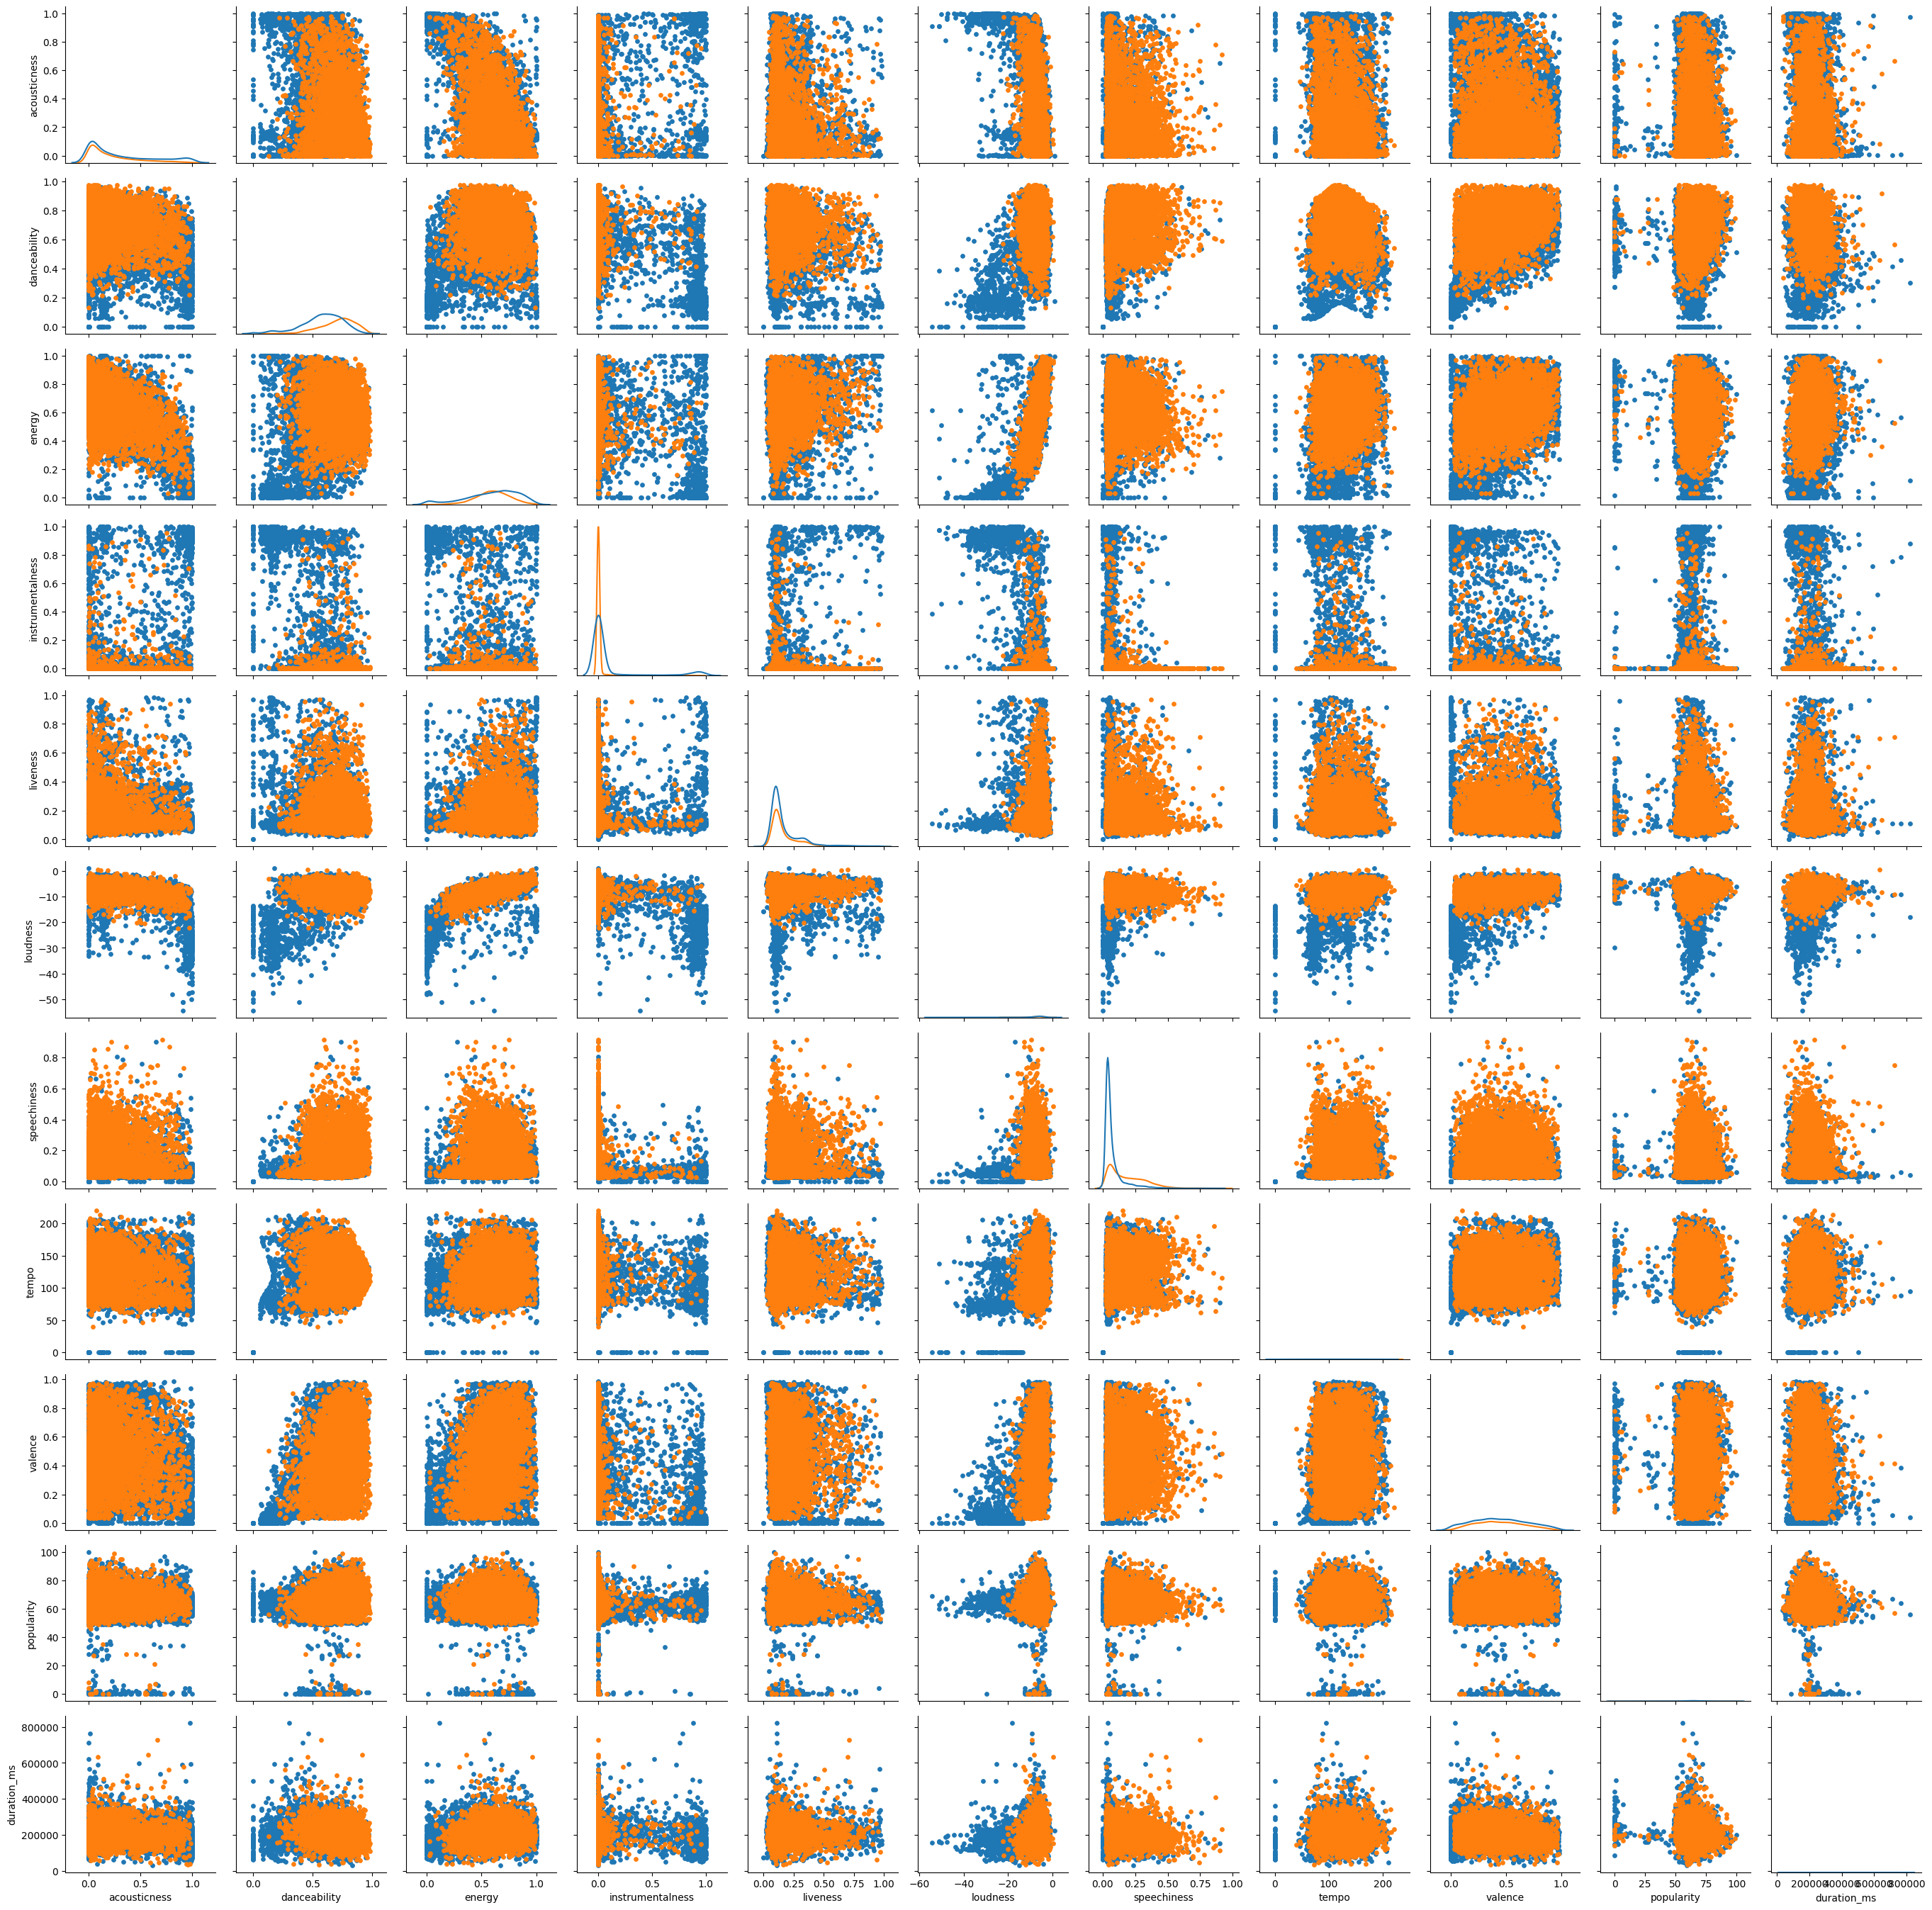

In [ ]:
# Pair Grid Visualization
p = sns.PairGrid(music_pd, vars=['acousticness', 'danceability', 'energy',
                                 'instrumentalness', 'liveness', 'loudness',
                                 'speechiness', 'tempo', 'valence', 'popularity',
                                 'duration_ms'], hue='explicit')
p.map_diag(sns.kdeplot)  # Kernel density on diagonal
p.map_offdiag(plt.scatter, s=15)  # Scatter plot on off-diagonal


##Popularity Distribution Visualization

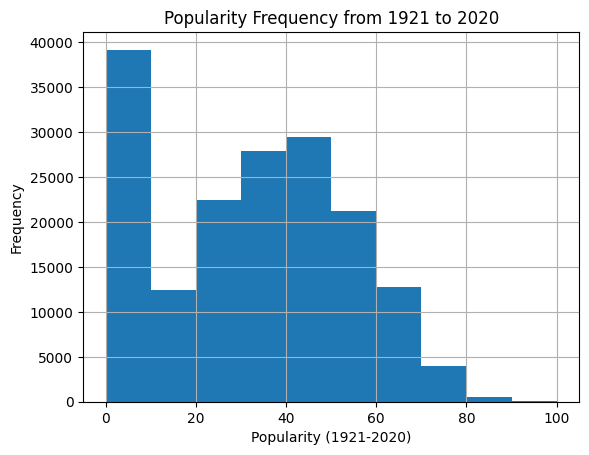

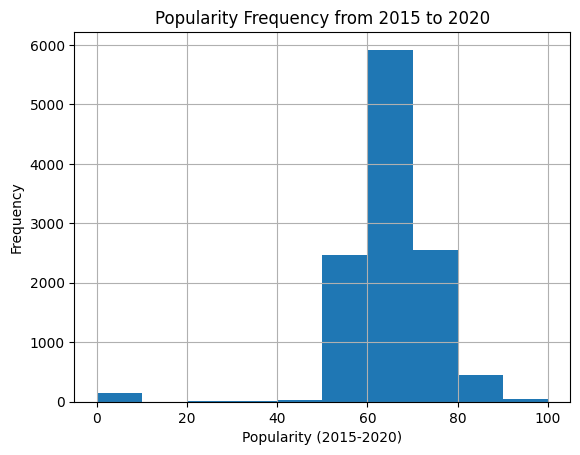

In [ ]:
# Popularity distribution from the original data (1921 - 2020)
raw_data['popularity'].hist()
plt.xlabel('Popularity (1921-2020)')
plt.ylabel('Frequency')
plt.title('Popularity Frequency from 1921 to 2020')
plt.show()

# Popularity distribution from the recent data (2015 - 2020)
music_2015_2020['popularity'].hist()
plt.xlabel('Popularity (2015-2020)')
plt.ylabel('Frequency')
plt.title('Popularity Frequency from 2015 to 2020')
plt.show()


##Annual Trend Analysis

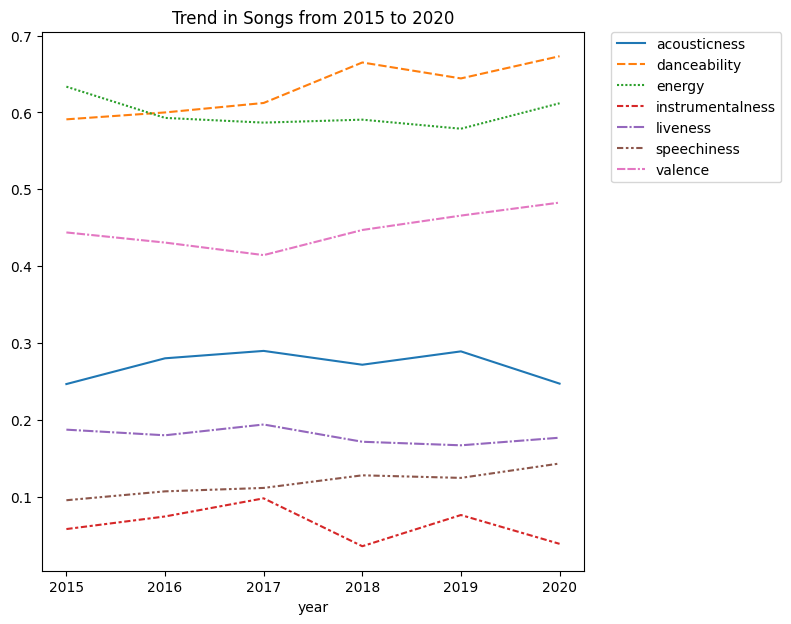

In [ ]:
# Isolate numeric columns for analysis
music_num = music_2015_2020.drop(['artists', 'explicit', 'mode', 'name',
                                  'release_date', 'key'], axis=1)

# Analyze trends by year
year_trend = music_num.groupby('year').mean().drop(['duration_ms', 'tempo',
                                                    'popularity', 'loudness'], axis=1)

# Plot yearly trend
plt.figure(figsize=(7, 7))
sns.lineplot(data=year_trend)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Trend in Songs from 2015 to 2020')
plt.show()


##Popularity vs Other Features

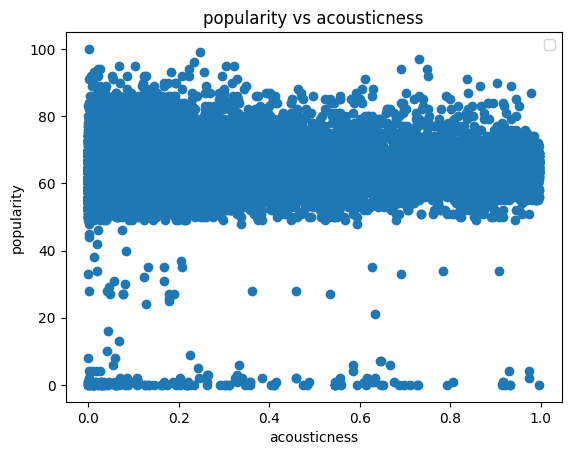

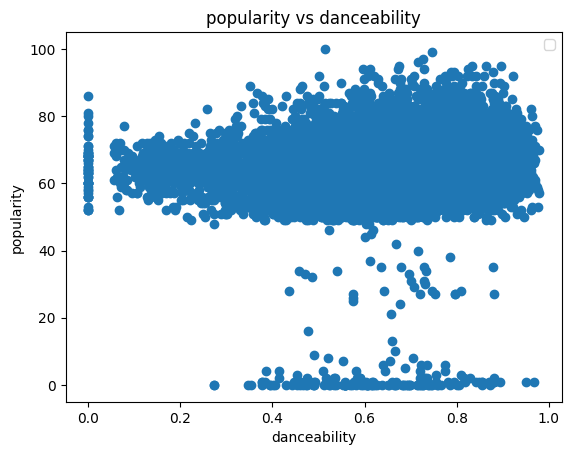

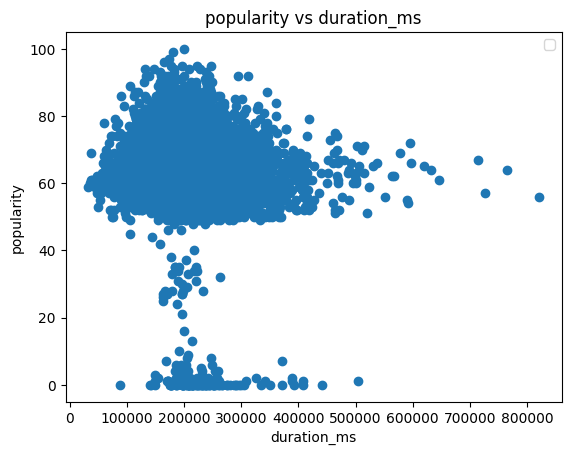

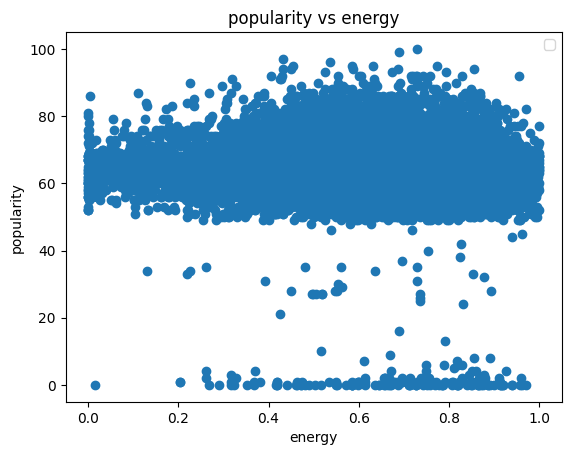

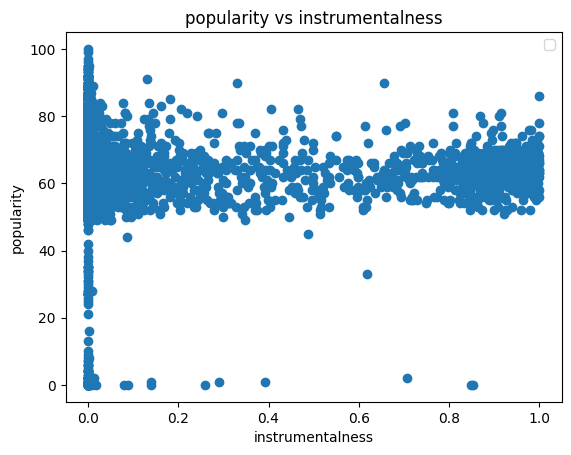

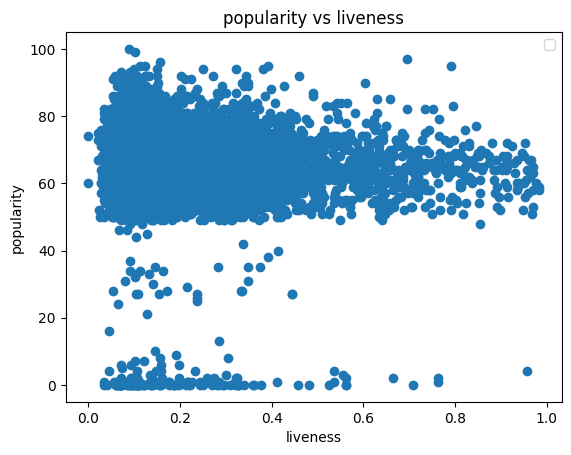

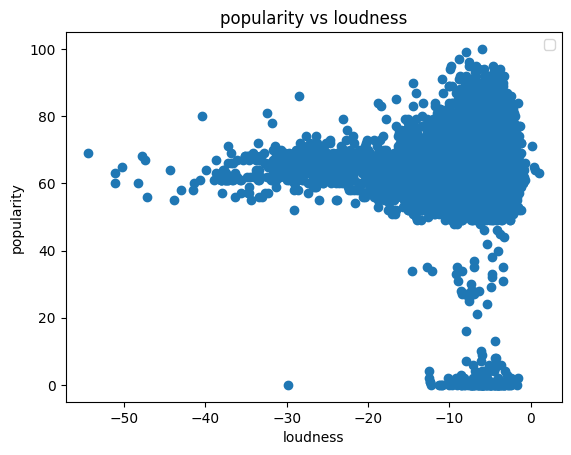

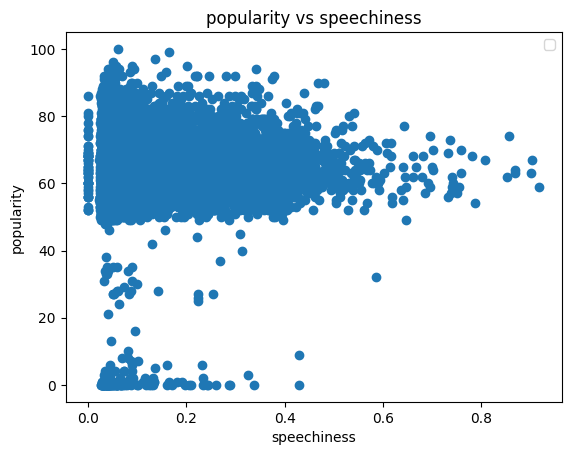

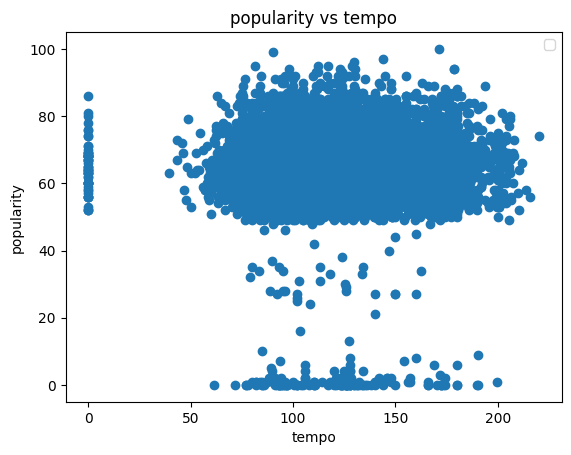

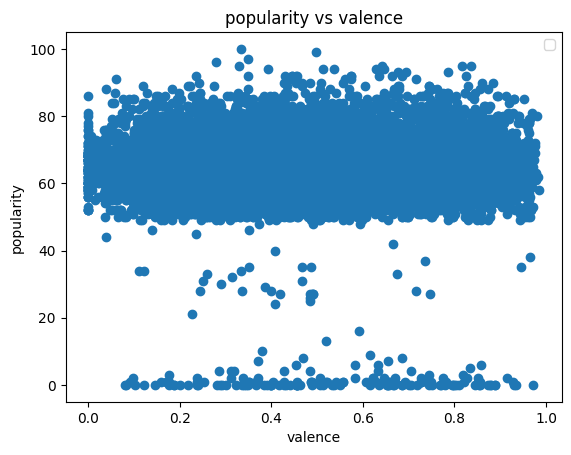

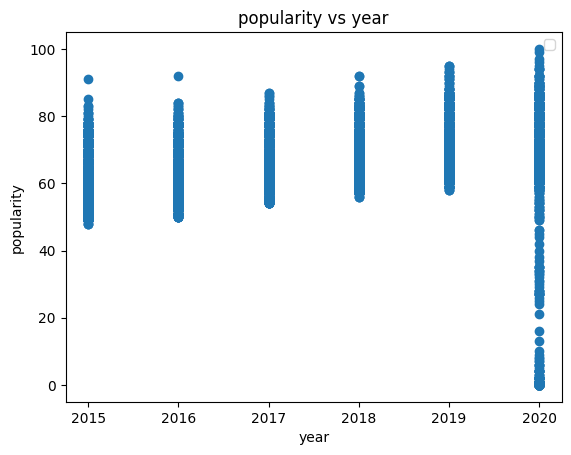

In [ ]:
# Plot popularity against all other features
y_col = 'popularity'
x_columns = music_num.columns.drop('popularity')

for x_col in x_columns:
    plt.figure()
    ax = plt.gca()
    ax.scatter(music_num[x_col], music_num[y_col])
    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    ax.set_title(f"{y_col} vs {x_col}")
    plt.legend()
    plt.show()


##Data Preparation for Linear Regression

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline

# Assemble features
assembler = VectorAssembler(inputCols=['danceability', 'energy', 'loudness', 'explicit', 'key'], outputCol='features')
feature_engineering_pipe = Pipeline(stages=[assembler])

# Transform the dataset and create 'music_df_xformed'
model = feature_engineering_pipe.fit(music_df)
music_df_xformed = model.transform(music_df)

# Split data into train, test, and validation sets
train, test, val = music_df_xformed.randomSplit([0.7, 0.2, 0.1], seed=11)


## Linear Regression - Model Training and Evaluation

In [ ]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# Initialize Linear Regression
linear_reg = LinearRegression(featuresCol="features", labelCol="popularity")
music_pipe = Pipeline(stages=[linear_reg])

# Train the model
model1 = music_pipe.fit(train)
linear_model = model1.stages[0]

# Report coefficients and intercept
print("Coefficients: " + str(linear_model.coefficients))
print("Intercept: " + str(linear_model.intercept))

# Evaluate the model
model1_output = linear_model.transform(train)
training_summary = linear_model.summary
print("RMSE of Linear Regression Model: %f" % training_summary.rootMeanSquaredError)
# Evaluate Linear Regression on the test set
lr_mse = model1_evaluator.evaluate(linear_model.transform(test))  # Store Linear Regression MSE
print("Linear Regression MSE:", lr_mse)
# Evaluate using MSE
model1_evaluator = RegressionEvaluator(predictionCol="prediction", metricName="mse", labelCol='popularity')
print('Training MSE value: ', model1_evaluator.evaluate(model1_output))
print('Testing MSE value: ', model1_evaluator.evaluate(linear_model.transform(test)))

# Show sample predictions
model1_output.select("prediction", "popularity", "features").show(5)


Coefficients: [6.524485123507765,-3.8305407574489467,0.03264683301180239,1.042314540699996,-0.004156936054755827]
Intercept: 62.377280937456156
RMSE of Linear Regression Model: 10.757353
Linear Regression MSE: 111.96043951020336
Training MSE value:  115.72064565716508
Testing MSE value:  111.96043951020336
+-----------------+----------+--------------------+
|       prediction|popularity|            features|
+-----------------+----------+--------------------+
|61.76424971166681|        52|[0.0,2.01E-5,-17....|
|61.42158847234436|        52|[0.0,1.99E-5,-29....|
|62.66746878770055|        63|[0.21,0.153,-15.1...|
|61.84138282571896|        74|[0.0,2.01E-5,-15....|
|59.65659665855957|        63|[0.17,0.847,-16.9...|
+-----------------+----------+--------------------+
only showing top 5 rows



##Random Forest - Model Training and Evaluation

In [ ]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator

# Feature indexing
feature_indexer = VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(music_df_xformed)

# Initialize Random Forest
rf = RandomForestRegressor(featuresCol="indexedFeatures", labelCol="popularity")
pipeline = Pipeline(stages=[feature_indexer, rf])

# Train Random Forest model
rf_model = pipeline.fit(train)
predictions = rf_model.transform(test)

# Evaluate using MSE
evaluator = RegressionEvaluator(labelCol="popularity", predictionCol="prediction", metricName="mse")
rf_mse = evaluator.evaluate(predictions)
print("MSE on test data = %g" % rf_mse)

# Evaluate Random Forest on the test set
rf_mse = evaluator.evaluate(predictions)  # Store Random Forest MSE
print("Random Forest MSE:", rf_mse)


# Show sample predictions
predictions.select("prediction", "popularity", "features").show(5)

# Extract the trained Random Forest model
rf_trained_model = rf_model.stages[1]
print(rf_trained_model)


MSE on test data = 109.023
Random Forest MSE: 109.02305061122418
+-----------------+----------+--------------------+
|       prediction|popularity|            features|
+-----------------+----------+--------------------+
|63.34536416759795|        63|[0.0,3.2200000000...|
|  63.039301421335|        60|[0.16699999999999...|
|62.04934200497594|        56|[0.49200000000000...|
|62.15114920592159|        65|[0.424,0.619,-5.9...|
|61.93762890274392|        54|[0.484,0.853,-4.5...|
+-----------------+----------+--------------------+
only showing top 5 rows

RandomForestRegressionModel: uid=RandomForestRegressor_f34394de07b8, numTrees=20, numFeatures=5


##Hyperparameter Tuning for Random Forest (Optional)

In [ ]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
enable_grid_search = True
if enable_grid_search:
    # Hyperparameter tuning for Random Forest
    param_grid = ParamGridBuilder() \
        .addGrid(rf.numTrees, [10, 30, 50]) \
        .addGrid(rf.maxDepth, [5, 15, 25]) \
        .build()

    evaluator = RegressionEvaluator(labelCol='popularity', predictionCol='prediction', metricName='rmse')
    cv = CrossValidator(estimator=pipeline, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=2)

    # Cross-validation model
    cv_model = cv.fit(train)
    best_rf_model = cv_model.bestModel.stages[1]

    # Report best parameters
    print("Best number of trees: ", best_rf_model.getNumTrees)
    print("Best max depth: ", best_rf_model.getOrDefault('maxDepth'))


Best number of trees:  50
Best max depth:  15


##Final Random Forest Model with Best Parameters

In [ ]:
# Best Random Forest model with tuned parameters
final_rf = RandomForestRegressor(featuresCol='features', labelCol='popularity', numTrees=50, maxDepth=5)
final_pipe = Pipeline(stages=[feature_indexer, final_rf])

# Train the model
final_rf_model = final_pipe.fit(train)

# Evaluate the final model
train_predictions = final_rf_model.transform(train)
test_predictions = final_rf_model.transform(test)

evaluator1 = RegressionEvaluator(labelCol='popularity', predictionCol='prediction', metricName="mse")
print("Training MSE: ", evaluator1.evaluate(train_predictions))
print("Testing MSE: ", evaluator1.evaluate(test_predictions))

# Feature importance
feature_importances = final_rf_model.stages[-1].featureImportances.toArray()
features = ['danceability', 'energy', 'loudness', 'explicit', 'key']
feature_scoring = pd.DataFrame(list(zip(features, feature_importances)),
                               columns=['feature_name', 'importance_score']).sort_values(by='importance_score', ascending=False)

print("Feature Importance:")
display(feature_scoring)


Training MSE:  109.80136973493656
Testing MSE:  109.51183335493012
Feature Importance:


,feature_name,importance_score
0,danceability,0.332899
1,energy,0.254036
2,loudness,0.233948
4,key,0.114018
3,explicit,0.065100


##Model Comparison

In [ ]:
# Compare Linear Regression and Random Forest models
compare_dict = {
    'model_name': ['Linear Regression', 'Random Forest'],
    'mse': [lr_mse, rf_mse],
    'rmse': [np.sqrt(lr_mse), np.sqrt(rf_mse)]
}

compare_df = pd.DataFrame.from_dict(compare_dict)
print("Model Comparison:")
display(compare_df)


Model Comparison:


,model_name,mse,rmse
0,Linear Regression,111.960440,10.581136
1,Random Forest,109.023051,10.441410


##PCA (Principal Component Analysis)
##PCA Pipeline Definition and Scree Plot

In [ ]:
from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA, Normalizer

# Define PCA pipeline
music_pipe = Pipeline(stages=[
    VectorAssembler(inputCols=['acousticness', 'danceability', 'energy', 'explicit',
                               'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
                               'speechiness', 'tempo', 'valence', 'year'], outputCol='features'),
    StandardScaler(withMean=True, withStd=True, inputCol='features', outputCol='centered_features'),
    Normalizer(inputCol='centered_features', outputCol='norm_features'),
    PCA(k=13, inputCol='centered_features', outputCol='pca_score')
])

# Fit PCA model and transform data
music_model = music_pipe.fit(music_df)
music_pca = music_model.transform(music_df)
music_pca.show()




+------------------+--------------------+------------------+-----------+------------------+--------+----------------+---+--------+-------------------+----+--------------------+----------+------------+-----------+------------------+------------------+----+--------------------+--------------------+--------------------+--------------------+
|      acousticness|             artists|      danceability|duration_ms|            energy|explicit|instrumentalness|key|liveness|           loudness|mode|                name|popularity|release_date|speechiness|             tempo|           valence|year|            features|   centered_features|       norm_features|           pca_score|
+------------------+--------------------+------------------+-----------+------------------+--------+----------------+---+--------+-------------------+----+--------------------+----------+------------+-----------+------------------+------------------+----+--------------------+--------------------+--------------------+--

Sum of Explained Variance: 1.0


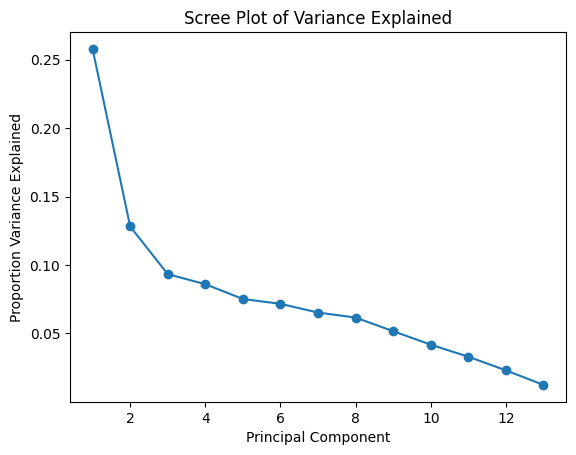

In [ ]:
# Explained variance
explained_var = music_model.stages[-1].explainedVariance
print("Sum of Explained Variance:", sum(explained_var))

# Scree Plot
plt.figure()
plt.plot(np.arange(1, len(explained_var)+1), explained_var, marker='o')
plt.title("Scree Plot of Variance Explained")
plt.xlabel("Principal Component")
plt.ylabel("Proportion Variance Explained")
plt.show()


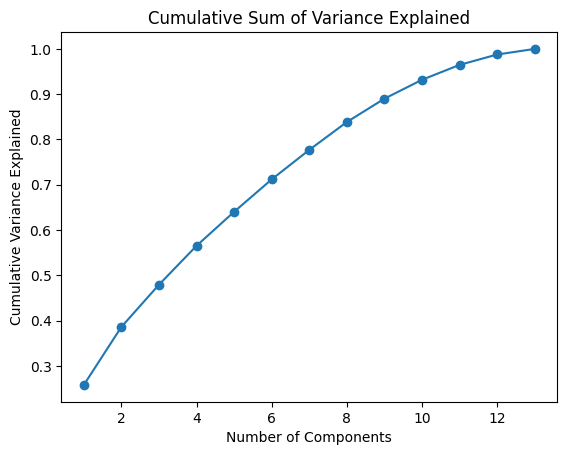

In [ ]:

# Cumulative Sum of Variance Explained
cum_sum = np.cumsum(explained_var)
plt.figure()
plt.plot(np.arange(1, len(explained_var)+1), cum_sum, marker='o')
plt.title("Cumulative Sum of Variance Explained")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Variance Explained")
plt.show()

##Final PCA with k=10

In [ ]:
# Redefine PCA pipeline with k=10
music_pipe_final = Pipeline(stages=[
    VectorAssembler(inputCols=['acousticness', 'danceability', 'energy', 'explicit',
                               'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
                               'speechiness', 'tempo', 'valence', 'year'], outputCol='features'),
    StandardScaler(withMean=True, withStd=True, inputCol='features', outputCol='centered_features'),
    Normalizer(inputCol='centered_features', outputCol='norm_features'),
    PCA(k=10, inputCol='centered_features', outputCol='pca_score')
])

# Fit final PCA model
music_model_final = music_pipe_final.fit(music_df)
music_pca_final = music_model_final.transform(music_df)
print("Sum of Explained Variance with k=10:", sum(music_model_final.stages[-1].explainedVariance))
music_pca_final.show()


Sum of Explained Variance with k=10: 0.931831680998153
+------------------+--------------------+------------------+-----------+------------------+--------+----------------+---+--------+-------------------+----+--------------------+----------+------------+-----------+------------------+------------------+----+--------------------+--------------------+--------------------+--------------------+
|      acousticness|             artists|      danceability|duration_ms|            energy|explicit|instrumentalness|key|liveness|           loudness|mode|                name|popularity|release_date|speechiness|             tempo|           valence|year|            features|   centered_features|       norm_features|           pca_score|
+------------------+--------------------+------------------+-----------+------------------+--------+----------------+---+--------+-------------------+----+--------------------+----------+------------+-----------+------------------+------------------+----+----------

##Recommendation System Based on PCA

In [ ]:
# Define function to calculate L2 distance
def l2_dist(c1, c2):
    return float(np.sqrt((c1 - c2).T.dot((c1 - c2))))

# Function to get nearest songs
def get_nearest_songs(song_name, num_nearest_songs):
    from pyspark.sql.types import FloatType
    l2_dist_udf = fn.udf(l2_dist, FloatType())

    # Compute distances
    song_df = music_pca_final \
        .where(music_pca_final.name == song_name) \
        .select(fn.col("pca_score").alias('song_scores')) \
        .join(music_pca_final) \
        .withColumn('dist', l2_dist_udf('pca_score', 'song_scores')) \
        .orderBy(fn.asc('dist')) \
        .where('dist != 0') \
        .select("name", 'artists', 'dist') \
        .limit(num_nearest_songs)

    return song_df.toPandas()

# Example usage
get_nearest_songs('Sad Forever', 5)


,name,artists,dist
0,17,['Pink Sweat$'],1.071972
1,Wonder What She Thinks of Me,['Chloe x Halle'],1.084852
2,Strangers,['Mt. Joy'],1.095840
3,How Would I Know,"['Kygo', 'Oh Wonder']",1.138228
4,Church In A Chevy,['Jordan Davis'],1.179639


##K-Means Clustering
Optimal Number of Clusters (Silhouette Score)

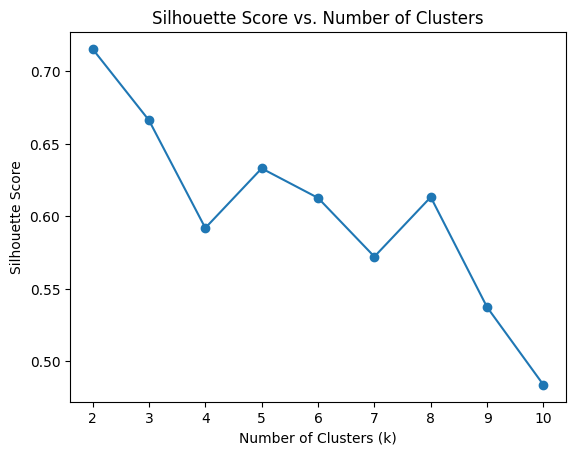

Optimal k: 2


In [ ]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

# Function to find optimal k
def optimal_k(df_in, k_min, k_max):
    silhouette_scores = []
    k_values = range(k_min, k_max + 1)

    for k in k_values:
        kmeans = KMeans(k=k, seed=42, featuresCol='features')
        model = kmeans.fit(df_in)
        predictions = model.transform(df_in)
        evaluator = ClusteringEvaluator()
        silhouette_scores.append(evaluator.evaluate(predictions))

    return k_values, silhouette_scores

# Find the optimal number of clusters
k_values, silhouette_scores = optimal_k(music_pca_final, k_min=2, k_max=10)

# Plot Silhouette Scores
plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of Clusters')
plt.show()

# Print the optimal k
optimal_k_value = k_values[np.argmax(silhouette_scores)]
print("Optimal k:", optimal_k_value)


##Final K-Means Model

In [ ]:
# Define K-Means pipeline with optimal k
music_kmeans_pipe = Pipeline(stages=[
    VectorAssembler(inputCols=['acousticness', 'danceability', 'energy', 'explicit',
                               'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
                               'speechiness', 'tempo', 'valence', 'year'], outputCol='features'),
    KMeans(k=optimal_k_value, seed=42, featuresCol='features')
])

# Fit K-Means model
music_kmeans_model = music_kmeans_pipe.fit(music_df)
music_kmeans = music_kmeans_model.transform(music_df)

# Show cluster assignments
music_kmeans.select("name", "artists", "prediction").show()

# Evaluate clustering
evaluator = ClusteringEvaluator()
silhouette_score = evaluator.evaluate(music_kmeans)
print("Silhouette Score for K-Means:", silhouette_score)

# Frequency of each cluster
freq_cluster = music_kmeans.groupby('prediction').count()
freq_cluster.orderBy('prediction').show()


+--------------------+--------------------+----------+
|                name|             artists|prediction|
+--------------------+--------------------+----------+
|         Wrong Turns|    ['Old Dominion']|         1|
|Desire - Gryffin ...|['Years & Years',...|         1|
|           Ave Maria|['Charles Gounod'...|         0|
|           Landslide|       ['Oh Wonder']|         0|
|               Up&Up|        ['Coldplay']|         1|
|             Drinkee|     ['Sofi Tukker']|         0|
|        Teenage Blue|       ['Dreamgirl']|         1|
|      Lost And Found|         ['Iration']|         1|
|      Heroes Tonight|['Janji', 'Johnni...|         1|
|Towards The Sun -...|         ['Rihanna']|         1|
|              Liquor|     ['Chris Brown']|         0|
|         Coffee Talk|       ['Broadside']|         1|
|                Prey|['The Neighbourho...|         0|
|        It Was A Sin| ['The Revivalists']|         1|
| Gimme All Your Love|  ['Alabama Shakes']|         0|
|         